In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.optim import Adam
from tqdm import tqdm

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
EPOCHS = 100

In [3]:
# batch size x channels x time x bands
valid_part = torch.rand((32, 1, 128, 64))

In [4]:
class HeadBlock(nn.Module):
    def __init__(self, input_features: int, output_classes: int):
        super().__init__()

        self.layers = nn.ModuleList(
            [
                nn.Flatten(),
                nn.Linear(input_features, output_classes),
                nn.Dropout2d(p=0.5),
            ]
        )

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

In [5]:
block_test = HeadBlock(8192, 5)
block_test(valid_part).shape

d:\Conda\envs\dl\Lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


torch.Size([32, 5])

In [6]:
class FeatureExtractionBlock(nn.Module):
    def __init__(
        self,
        input_channels: int,
        output_channels: int,
        conv_kernel_size: int = 3,
        conv_stride: int = 2,
        conv_padding: int = 1,
        pooling_kernel_size: int = 2,
    ):
        super().__init__()

        self.layers = nn.ModuleList(
            [
                nn.Conv2d(
                    input_channels,
                    output_channels,
                    kernel_size=conv_kernel_size,
                    stride=conv_stride,
                    padding=conv_padding,
                ),
                nn.LeakyReLU(negative_slope=0.01),
                nn.MaxPool2d(kernel_size=pooling_kernel_size),
                nn.BatchNorm2d(output_channels),
                nn.Dropout2d(p=0.2),
            ]
        )

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

In [7]:
extraction_test = FeatureExtractionBlock(1, 32)
extraction_test(valid_part).shape

torch.Size([32, 32, 32, 16])

In [ ]:
class BirdClassifier(nn.Module):
    def __init__(
        self,
        output_classes: int,
        input_channels: int,
        validation_tensor: torch.Tensor,
    ):
        super().__init__()
        # Entry extractor
        self.entry_extractor_output_channels = 32
        self.entry_extractor = FeatureExtractionBlock(
            input_channels, self.entry_extractor_output_channels
        )
        self.second_extractor = FeatureExtractionBlock(self.entry_extractor_output_channels, 64)
        self.third_extractor = FeatureExtractionBlock(64, 128)

        output = self.entry_extractor(validation_tensor)
        output = self.second_extractor(output)
        output = self.third_extractor(output)
        
        head_input_features = (
            output.shape[1]
            * output.shape[2]
            * output.shape[3]
        )
        self.head = HeadBlock(head_input_features, output_classes)

    def forward(self, x):
        out = x
        out = self.entry_extractor(x)
        out = self.second_extractor(out)
        out = self.third_extractor(out)
        return self.head(out)

In [9]:
class BirdClassifierManager:
    def __init__(
        self,
        output_classes: int,
        input_channels: int,
        validation_tensor: torch.Tensor,
        load_model: bool = False,
        model_path="./bird_classifier.pth",
        device: str = DEVICE,
    ):
        self.model_path = model_path
        self.device = device
        if load_model:
            self.load_model()
        else:
            self.model = BirdClassifier(
                output_classes, input_channels, validation_tensor
            ).to(self.device)

        self.validation_tensor = validation_tensor

    def validate(self):
        try:
            self.model(self.validation_tensor)
            print("OK!")
        except Exception as e:
            print(f"Validation failed: {e}")

    def predict(self, sample: torch.Tensor):
        sample = sample.to(self.device)
        with torch.no_grad():
            return self.model(sample)

    def save_model(self):
        torch.save(self.model, self.model_path)

    def load_model(self):
        self.model.load_state_dict(torch.load(self.model_path))
        self.model.to(self.device)

    def train(
        self, train: Dataset, valid: Dataset, epochs: int = EPOCHS, lr: float = 0.0001
    ):
        criterion = nn.CrossEntropyLoss()
        optimizer = Adam(self.model.parameters(), lr=lr)

        for epoch in range(epochs):
            self.model.train()
            train_loss = 0.0
            correct_train = 0
            total_train = 0

            for inputs, labels in tqdm(train):
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                correct_train += predicted.eq(labels).sum().item()
                total_train += labels.size(0)

            train_loss /= len(train)
            train_accuracy = 100 * correct_train / total_train

            if epoch % 5 == 0:
                self.save_model()

            self.model.eval()
            valid_loss = 0.0
            correct_valid = 0
            total_valid = 0

            with torch.no_grad():
                for inputs, labels in valid:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = self.model(inputs)
                    loss = criterion(outputs, labels)

                    valid_loss += loss.item() * inputs.size(0)
                    _, predicted = outputs.max(1)
                    correct_valid += predicted.eq(labels).sum().item()
                    total_valid += labels.size(0)

            valid_loss /= len(valid)
            valid_accuracy = 100 * correct_valid / total_valid

            print(
                f"Epoch [{epoch+1}/{epochs}] "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% "
                f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%"
            )

    def test(self, test: Dataset):
        self.model.eval()
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for inputs, labels in test:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = outputs.max(1)
                correct_test += predicted.eq(labels).sum().item()
                total_test += labels.size(0)

        test_accuracy = 100 * correct_test / total_test
        print(f"Test Accuracy: {test_accuracy:.2f}%")

In [10]:
import os
import torchaudio
import numpy as np
import pandas as pd
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [11]:
class BirdSongDataset(Dataset):
    def __init__(
        self,
        x: pd.DataFrame,
        y: pd.DataFrame,
        sample_rate: int,
        num_samples: int,
        as_mel_spectogram: bool = True,
    ):
        super().__init__()
        self.x = x
        self.y = y
        self.target_sample_rate = sample_rate
        self.target_number_of_samples = num_samples
        self.as_mel_spectogram = as_mel_spectogram
        self.mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.target_sample_rate, n_fft=1024, hop_length=512, n_mels=96
        )

    def _resample_if_necessary(self, waveform: torch.Tensor, sample_rate: int):
        if sample_rate != self.target_sample_rate:
            resample_transform = torchaudio.transforms.Resample(
                orig_freq=sample_rate, new_freq=self.target_sample_rate
            )
            waveform = resample_transform(waveform)
        return waveform

    def _pad_or_trim(self, waveform: torch.Tensor):
        if waveform.shape[1] > self.target_number_of_samples:
            waveform = waveform[:, : self.target_number_of_samples]
        elif waveform.shape[1] < self.target_number_of_samples:
            padding = self.target_number_of_samples - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))
        return waveform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        path, class_ = self.x[index], self.y[index]

        waveform, sample_rate = torchaudio.load(str(path))
        waveform = self._resample_if_necessary(waveform, sample_rate)
        waveform = self._pad_or_trim(waveform)

        if self.as_mel_spectogram:
            waveform = self.mel_spectrogram_transform(waveform)

        return waveform, class_

In [12]:
import torchaudio
import os
import pandas as pd
from torch.utils.data import DataLoader
from pathlib import Path


class BirdSongDatasetManager:
    def __init__(
        self,
        csv_file_path: Path,
        audio_files_main_folder: Path,
        train: float = 0.9,
        valid: float = 0.05,
        test: float = 0.05,
        batch_size: int = 32,
        shuffle: bool = True,
        csv_file_name: str = "train_mod.csv",
        minimum_files_num=100,
        min_duration_seconds=40,
        sample_rate: int = 32000,
        num_samples: int = 960_000,
    ):
        if not np.isclose((train + valid + test), 1):
            raise Exception("Sum of dataset partitions must be equal to 1")

        self.csv_file_path = csv_file_path
        self.audio_files_main_folder = audio_files_main_folder
        self.train = train
        self.valid = valid
        self.test = test
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.csv_file_name = csv_file_name
        self.number_of_classes = 0
        self.minimum_files_num = minimum_files_num
        self.min_duration_seconds = min_duration_seconds

        self.index_to_class, self.class_to_index = dict(), dict()

        self.dataframe, self.species_to_name = self._filter_data(
            self.csv_file_path, self.audio_files_main_folder
        )
        self.species_in_dataset = self.dataframe["ebird_code"].unique()

        self.mapped_dataframe = self._map_bird_to_path()

        self.dataset_loaders_args = dict(
            sample_rate=sample_rate, num_samples=num_samples
        )

    def _filter_data(
        self, csv_file_path: Path, audio_files_main_folder: Path
    ) -> pd.DataFrame:
        dataframe = pd.read_csv(csv_file_path)

        current_dataset_species = os.listdir(audio_files_main_folder)
        current_dataset_species.remove(self.csv_file_name)

        ebird_code_to_name = dict()
        class_ = 0
        for species in current_dataset_species:
            species_path = audio_files_main_folder / species
            if len(os.listdir(species_path)) >= self.minimum_files_num:
                name = dataframe[dataframe["ebird_code"] == species].iloc[0]["species"]

                self.class_to_index[name] = class_
                self.index_to_class[class_] = name
                ebird_code_to_name[species] = name

                class_ += 1

        self.number_of_classes = class_

        # Filter dataframe by valid species only
        valid_species = dataframe[
            dataframe["ebird_code"].isin(ebird_code_to_name.keys())
        ]

        return valid_species, ebird_code_to_name

    def _map_bird_to_path(self) -> pd.DataFrame:
        data = []
        for species in self.species_in_dataset:
            prefix = self.audio_files_main_folder / species
            audio_files = os.listdir(prefix)
            for file in audio_files:
                file_path = prefix / file

                class_code = self.species_to_name[species]
                data.append(
                    {
                        "class": self.class_to_index[class_code],
                        "file_path": file_path,
                        "class_name": class_code,
                        "ebird_code": species,
                    }
                )

                # Only include files that are at least the minimum duration
                # if duration_seconds >= self.min_duration_seconds:

        return pd.DataFrame(data)

    def get_datasets(self, with_valid: bool = True):
        train_data = []
        valid_data = []
        test_data = []

        # Filter only species with valid files based on the duration
        valid_species = self.mapped_dataframe.groupby("ebird_code").filter(
            lambda group: len(group) >= self.minimum_files_num
        )
        print(
            f"Number of species with at least {self.minimum_files_num} files: {len(valid_species['ebird_code'].unique())}"
        )

        min_group_size = min(valid_species.groupby("ebird_code").size())
        print(
            f"Minimum group size (after filtering species with fewer than {self.minimum_files_num} files): {min_group_size}"
        )

        for _, group in valid_species.groupby("ebird_code"):
            # Sample to ensure equal group size across all species
            group = group.sample(n=min_group_size, random_state=42).reset_index(
                drop=True
            )
            n = len(group)
            train_end = int(self.train * n)
            valid_end = train_end + int(self.valid * n) if with_valid else train_end

            train_data.append(group.iloc[:train_end])
            if with_valid:
                valid_data.append(group.iloc[train_end:valid_end])
                test_data.append(group.iloc[valid_end:])
            else:
                test_data.append(group.iloc[train_end:])

        # Concatenate the data into DataFrames
        train_df = pd.concat(train_data).reset_index(drop=True)
        valid_df = pd.concat(valid_data).reset_index(drop=True) if with_valid else None
        test_df = pd.concat(test_data).reset_index(drop=True)

        # Create DataLoaders
        train = DataLoader(
            BirdSongDataset(
                train_df["file_path"], train_df["class"], **self.dataset_loaders_args
            ),
            batch_size=self.batch_size,
            shuffle=self.shuffle,
        )

        valid = (
            DataLoader(
                BirdSongDataset(
                    valid_df["file_path"],
                    valid_df["class"],
                    **self.dataset_loaders_args,
                )
            )
            if with_valid
            else None
        )

        test = DataLoader(
            BirdSongDataset(
                test_df["file_path"], test_df["class"], **self.dataset_loaders_args
            )
        )

        return train, valid, test

In [13]:
dataset_manager = BirdSongDatasetManager(Path("data/train_mod.csv"), Path("data"))

In [14]:
dataset_manager.class_to_index

{'Cactus Wren': 0,
 'Canada Goose': 1,
 'Canada Warbler': 2,
 'Canyon Wren': 3,
 'Carolina Wren': 4,
 'Caspian Tern': 5,
 'Chipping Sparrow': 6,
 'Chestnut-sided Warbler': 7,
 'Common Grackle': 8,
 'Northern Raven': 9,
 'Common Redpoll': 10,
 'Common Tern': 11,
 'Common Yellowthroat': 12,
 'Dark-eyed Junco': 13,
 'Downy Woodpecker': 14,
 'Eastern Meadowlark': 15,
 'Eastern Towhee': 16,
 'Eastern Wood Pewee': 17,
 'Eurasian Collared Dove': 18,
 'Evening Grosbeak': 19,
 'Field Sparrow': 20,
 'Red Fox Sparrow': 21}

In [15]:
train_part, valid_part, test_part = dataset_manager.get_datasets()

Number of species with at least 100 files: 22
Minimum group size (after filtering species with fewer than 100 files): 100


In [16]:
x = next(iter(train_part))
x[0].shape, x[1]

(torch.Size([32, 1, 96, 1876]),
 tensor([ 3, 21, 11,  4,  9, 16, 16,  7,  6,  6,  9,  5, 14, 12, 13,  0,  9,  4,
          3, 17, 12,  3,  3,  3, 20, 16, 21,  7, 20,  9,  0, 18]))

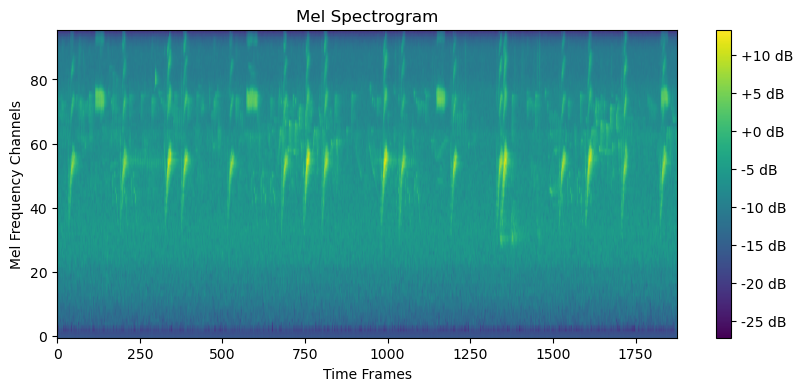

In [17]:
plt.figure(figsize=(10, 4))
plt.imshow(x[0][5].log2()[0, :, :].numpy(), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectrogram")
plt.xlabel("Time Frames")
plt.ylabel("Mel Frequency Channels")
plt.show()

In [18]:
valid = x[0]
model_manager = BirdClassifierManager(dataset_manager.number_of_classes, 1, valid)
model_manager.validate()
model_manager.predict(valid).shape

Validation failed: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor


d:\Conda\envs\dl\Lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


torch.Size([32, 22])

In [19]:
model_manager.train(train_part, valid_part)

  0%|          | 0/62 [00:00<?, ?it/s]d:\Conda\envs\dl\Lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
100%|██████████| 62/62 [01:05<00:00,  1.06s/it]


Epoch [1/100] Train Loss: 107.8833, Train Acc: 5.71% Valid Loss: 3.1057, Valid Acc: 11.82%


100%|██████████| 62/62 [02:44<00:00,  2.65s/it]


Epoch [2/100] Train Loss: 101.7786, Train Acc: 8.59% Valid Loss: 3.0625, Valid Acc: 16.36%


100%|██████████| 62/62 [01:06<00:00,  1.08s/it]


Epoch [3/100] Train Loss: 98.9014, Train Acc: 11.26% Valid Loss: 3.0317, Valid Acc: 14.55%


100%|██████████| 62/62 [01:07<00:00,  1.08s/it]


Epoch [4/100] Train Loss: 97.7521, Train Acc: 11.06% Valid Loss: 2.9858, Valid Acc: 19.09%


100%|██████████| 62/62 [01:08<00:00,  1.11s/it]


Epoch [5/100] Train Loss: 96.1008, Train Acc: 12.37% Valid Loss: 2.9671, Valid Acc: 15.45%


100%|██████████| 62/62 [01:07<00:00,  1.08s/it]


Epoch [6/100] Train Loss: 94.3591, Train Acc: 13.48% Valid Loss: 2.9643, Valid Acc: 19.09%


100%|██████████| 62/62 [01:06<00:00,  1.07s/it]


Epoch [7/100] Train Loss: 93.5118, Train Acc: 14.44% Valid Loss: 2.9261, Valid Acc: 19.09%


100%|██████████| 62/62 [01:07<00:00,  1.09s/it]


Epoch [8/100] Train Loss: 92.1635, Train Acc: 15.81% Valid Loss: 2.8864, Valid Acc: 20.00%


100%|██████████| 62/62 [01:08<00:00,  1.11s/it]


Epoch [9/100] Train Loss: 92.2454, Train Acc: 15.45% Valid Loss: 2.9420, Valid Acc: 19.09%


100%|██████████| 62/62 [01:08<00:00,  1.10s/it]


Epoch [10/100] Train Loss: 90.5468, Train Acc: 16.72% Valid Loss: 2.9022, Valid Acc: 20.00%


100%|██████████| 62/62 [01:08<00:00,  1.11s/it]


Epoch [11/100] Train Loss: 89.7752, Train Acc: 18.99% Valid Loss: 2.8440, Valid Acc: 20.00%


100%|██████████| 62/62 [01:09<00:00,  1.12s/it]


Epoch [12/100] Train Loss: 90.0063, Train Acc: 18.59% Valid Loss: 2.8591, Valid Acc: 20.91%


100%|██████████| 62/62 [01:10<00:00,  1.14s/it]


Epoch [13/100] Train Loss: 88.0742, Train Acc: 19.34% Valid Loss: 2.8212, Valid Acc: 26.36%


100%|██████████| 62/62 [01:09<00:00,  1.12s/it]


Epoch [14/100] Train Loss: 88.9219, Train Acc: 20.00% Valid Loss: 2.8463, Valid Acc: 26.36%


100%|██████████| 62/62 [01:08<00:00,  1.11s/it]


Epoch [15/100] Train Loss: 86.8759, Train Acc: 21.82% Valid Loss: 2.8111, Valid Acc: 27.27%


100%|██████████| 62/62 [01:06<00:00,  1.08s/it]


Epoch [16/100] Train Loss: 86.7137, Train Acc: 21.82% Valid Loss: 2.8119, Valid Acc: 22.73%


100%|██████████| 62/62 [01:06<00:00,  1.07s/it]


Epoch [17/100] Train Loss: 86.1291, Train Acc: 21.52% Valid Loss: 2.7746, Valid Acc: 27.27%


100%|██████████| 62/62 [01:09<00:00,  1.12s/it]


Epoch [18/100] Train Loss: 84.4632, Train Acc: 23.38% Valid Loss: 2.7913, Valid Acc: 20.91%


100%|██████████| 62/62 [01:11<00:00,  1.15s/it]


Epoch [19/100] Train Loss: 85.7635, Train Acc: 22.68% Valid Loss: 2.7622, Valid Acc: 27.27%


100%|██████████| 62/62 [01:24<00:00,  1.36s/it]


Epoch [20/100] Train Loss: 84.4495, Train Acc: 23.99% Valid Loss: 2.7985, Valid Acc: 25.45%


100%|██████████| 62/62 [01:13<00:00,  1.18s/it]


Epoch [21/100] Train Loss: 84.4093, Train Acc: 23.89% Valid Loss: 2.7640, Valid Acc: 30.00%


100%|██████████| 62/62 [01:04<00:00,  1.04s/it]


Epoch [22/100] Train Loss: 84.5761, Train Acc: 23.99% Valid Loss: 2.8008, Valid Acc: 28.18%


100%|██████████| 62/62 [01:05<00:00,  1.05s/it]


Epoch [23/100] Train Loss: 84.3862, Train Acc: 23.79% Valid Loss: 2.7540, Valid Acc: 29.09%


100%|██████████| 62/62 [01:02<00:00,  1.01s/it]


Epoch [24/100] Train Loss: 82.1804, Train Acc: 26.26% Valid Loss: 2.7518, Valid Acc: 25.45%


100%|██████████| 62/62 [01:12<00:00,  1.17s/it]


Epoch [25/100] Train Loss: 81.7565, Train Acc: 27.07% Valid Loss: 2.7477, Valid Acc: 26.36%


100%|██████████| 62/62 [01:01<00:00,  1.01it/s]


Epoch [26/100] Train Loss: 82.6985, Train Acc: 24.80% Valid Loss: 2.7446, Valid Acc: 25.45%


100%|██████████| 62/62 [01:02<00:00,  1.01s/it]


Epoch [27/100] Train Loss: 83.0331, Train Acc: 25.00% Valid Loss: 2.7372, Valid Acc: 30.00%


100%|██████████| 62/62 [00:55<00:00,  1.11it/s]


Epoch [28/100] Train Loss: 80.9871, Train Acc: 26.97% Valid Loss: 2.7614, Valid Acc: 30.00%


100%|██████████| 62/62 [00:57<00:00,  1.08it/s]


Epoch [29/100] Train Loss: 80.7772, Train Acc: 27.22% Valid Loss: 2.7660, Valid Acc: 28.18%


100%|██████████| 62/62 [00:58<00:00,  1.06it/s]


Epoch [30/100] Train Loss: 80.0568, Train Acc: 27.53% Valid Loss: 2.7781, Valid Acc: 25.45%


100%|██████████| 62/62 [00:54<00:00,  1.14it/s]


Epoch [31/100] Train Loss: 80.1779, Train Acc: 27.53% Valid Loss: 2.7808, Valid Acc: 25.45%


100%|██████████| 62/62 [01:03<00:00,  1.02s/it]


Epoch [32/100] Train Loss: 80.3794, Train Acc: 28.23% Valid Loss: 2.7475, Valid Acc: 27.27%


100%|██████████| 62/62 [00:58<00:00,  1.07it/s]


Epoch [33/100] Train Loss: 79.0309, Train Acc: 29.60% Valid Loss: 2.7246, Valid Acc: 25.45%


100%|██████████| 62/62 [00:59<00:00,  1.03it/s]


Epoch [34/100] Train Loss: 79.0635, Train Acc: 28.59% Valid Loss: 2.7194, Valid Acc: 26.36%


100%|██████████| 62/62 [01:01<00:00,  1.00it/s]


Epoch [35/100] Train Loss: 77.9951, Train Acc: 29.39% Valid Loss: 2.7111, Valid Acc: 24.55%


100%|██████████| 62/62 [01:06<00:00,  1.07s/it]


Epoch [36/100] Train Loss: 77.7154, Train Acc: 29.65% Valid Loss: 2.7165, Valid Acc: 25.45%


100%|██████████| 62/62 [01:07<00:00,  1.08s/it]


Epoch [37/100] Train Loss: 78.7673, Train Acc: 29.24% Valid Loss: 2.7127, Valid Acc: 28.18%


100%|██████████| 62/62 [01:02<00:00,  1.01s/it]


Epoch [38/100] Train Loss: 78.1318, Train Acc: 28.64% Valid Loss: 2.6825, Valid Acc: 27.27%


100%|██████████| 62/62 [01:00<00:00,  1.02it/s]


Epoch [39/100] Train Loss: 77.6333, Train Acc: 29.90% Valid Loss: 2.6632, Valid Acc: 25.45%


100%|██████████| 62/62 [01:00<00:00,  1.02it/s]


Epoch [40/100] Train Loss: 76.4934, Train Acc: 30.86% Valid Loss: 2.6692, Valid Acc: 26.36%


100%|██████████| 62/62 [01:01<00:00,  1.01it/s]


Epoch [41/100] Train Loss: 76.5655, Train Acc: 30.76% Valid Loss: 2.6833, Valid Acc: 25.45%


100%|██████████| 62/62 [01:06<00:00,  1.07s/it]


Epoch [42/100] Train Loss: 75.9589, Train Acc: 31.31% Valid Loss: 2.6769, Valid Acc: 29.09%


100%|██████████| 62/62 [01:01<00:00,  1.01it/s]


Epoch [43/100] Train Loss: 75.7683, Train Acc: 31.11% Valid Loss: 2.6708, Valid Acc: 27.27%


100%|██████████| 62/62 [01:01<00:00,  1.00it/s]


Epoch [44/100] Train Loss: 76.2550, Train Acc: 30.76% Valid Loss: 2.6616, Valid Acc: 25.45%


100%|██████████| 62/62 [01:03<00:00,  1.02s/it]


Epoch [45/100] Train Loss: 75.1091, Train Acc: 32.58% Valid Loss: 2.6406, Valid Acc: 26.36%


100%|██████████| 62/62 [01:00<00:00,  1.02it/s]


Epoch [46/100] Train Loss: 75.4882, Train Acc: 31.41% Valid Loss: 2.6450, Valid Acc: 28.18%


100%|██████████| 62/62 [01:02<00:00,  1.00s/it]


Epoch [47/100] Train Loss: 74.0969, Train Acc: 32.73% Valid Loss: 2.6450, Valid Acc: 28.18%


100%|██████████| 62/62 [00:59<00:00,  1.04it/s]


Epoch [48/100] Train Loss: 72.9320, Train Acc: 33.13% Valid Loss: 2.6342, Valid Acc: 23.64%


100%|██████████| 62/62 [00:58<00:00,  1.07it/s]


Epoch [49/100] Train Loss: 73.1217, Train Acc: 32.32% Valid Loss: 2.6001, Valid Acc: 29.09%


100%|██████████| 62/62 [01:01<00:00,  1.01it/s]


Epoch [50/100] Train Loss: 72.5243, Train Acc: 34.60% Valid Loss: 2.5979, Valid Acc: 29.09%


100%|██████████| 62/62 [00:57<00:00,  1.08it/s]


Epoch [51/100] Train Loss: 73.9791, Train Acc: 32.73% Valid Loss: 2.6109, Valid Acc: 30.00%


100%|██████████| 62/62 [01:00<00:00,  1.02it/s]


Epoch [52/100] Train Loss: 72.0657, Train Acc: 35.35% Valid Loss: 2.5793, Valid Acc: 30.91%


100%|██████████| 62/62 [01:05<00:00,  1.06s/it]


Epoch [53/100] Train Loss: 73.6077, Train Acc: 32.98% Valid Loss: 2.5878, Valid Acc: 28.18%


100%|██████████| 62/62 [01:05<00:00,  1.05s/it]


Epoch [54/100] Train Loss: 72.6970, Train Acc: 32.73% Valid Loss: 2.5638, Valid Acc: 28.18%


100%|██████████| 62/62 [01:05<00:00,  1.06s/it]


Epoch [55/100] Train Loss: 71.4431, Train Acc: 35.51% Valid Loss: 2.5551, Valid Acc: 29.09%


100%|██████████| 62/62 [01:04<00:00,  1.04s/it]


Epoch [56/100] Train Loss: 72.1055, Train Acc: 34.24% Valid Loss: 2.5661, Valid Acc: 30.00%


100%|██████████| 62/62 [01:05<00:00,  1.05s/it]


Epoch [57/100] Train Loss: 71.4647, Train Acc: 34.70% Valid Loss: 2.5492, Valid Acc: 29.09%


100%|██████████| 62/62 [01:08<00:00,  1.10s/it]


Epoch [58/100] Train Loss: 71.0266, Train Acc: 35.71% Valid Loss: 2.5399, Valid Acc: 27.27%


100%|██████████| 62/62 [01:09<00:00,  1.12s/it]


Epoch [59/100] Train Loss: 71.1972, Train Acc: 34.85% Valid Loss: 2.5459, Valid Acc: 31.82%


100%|██████████| 62/62 [01:05<00:00,  1.06s/it]


Epoch [60/100] Train Loss: 70.7703, Train Acc: 34.85% Valid Loss: 2.5691, Valid Acc: 29.09%


100%|██████████| 62/62 [01:01<00:00,  1.01it/s]


Epoch [61/100] Train Loss: 69.9699, Train Acc: 35.10% Valid Loss: 2.5129, Valid Acc: 30.00%


100%|██████████| 62/62 [01:02<00:00,  1.00s/it]


Epoch [62/100] Train Loss: 69.9312, Train Acc: 35.40% Valid Loss: 2.5468, Valid Acc: 29.09%


100%|██████████| 62/62 [01:03<00:00,  1.03s/it]


Epoch [63/100] Train Loss: 69.7817, Train Acc: 35.56% Valid Loss: 2.5067, Valid Acc: 30.91%


100%|██████████| 62/62 [01:03<00:00,  1.02s/it]


Epoch [64/100] Train Loss: 69.8574, Train Acc: 35.86% Valid Loss: 2.4973, Valid Acc: 28.18%


100%|██████████| 62/62 [01:01<00:00,  1.01it/s]


Epoch [65/100] Train Loss: 69.5899, Train Acc: 36.06% Valid Loss: 2.5157, Valid Acc: 28.18%


100%|██████████| 62/62 [01:03<00:00,  1.02s/it]


Epoch [66/100] Train Loss: 68.3407, Train Acc: 36.72% Valid Loss: 2.4848, Valid Acc: 29.09%


100%|██████████| 62/62 [01:06<00:00,  1.07s/it]


Epoch [67/100] Train Loss: 68.3494, Train Acc: 37.53% Valid Loss: 2.4920, Valid Acc: 26.36%


100%|██████████| 62/62 [01:05<00:00,  1.06s/it]


Epoch [68/100] Train Loss: 69.6171, Train Acc: 35.45% Valid Loss: 2.5205, Valid Acc: 27.27%


100%|██████████| 62/62 [01:04<00:00,  1.04s/it]


Epoch [69/100] Train Loss: 67.8566, Train Acc: 36.01% Valid Loss: 2.4771, Valid Acc: 28.18%


100%|██████████| 62/62 [01:05<00:00,  1.06s/it]


Epoch [70/100] Train Loss: 68.6560, Train Acc: 36.01% Valid Loss: 2.4799, Valid Acc: 30.00%


100%|██████████| 62/62 [01:08<00:00,  1.11s/it]


Epoch [71/100] Train Loss: 67.4726, Train Acc: 37.68% Valid Loss: 2.4680, Valid Acc: 30.00%


100%|██████████| 62/62 [01:09<00:00,  1.13s/it]


Epoch [72/100] Train Loss: 67.4437, Train Acc: 37.17% Valid Loss: 2.4713, Valid Acc: 33.64%


100%|██████████| 62/62 [01:15<00:00,  1.21s/it]


Epoch [73/100] Train Loss: 68.4171, Train Acc: 36.57% Valid Loss: 2.4894, Valid Acc: 31.82%


100%|██████████| 62/62 [01:17<00:00,  1.25s/it]


Epoch [74/100] Train Loss: 67.8996, Train Acc: 36.62% Valid Loss: 2.4958, Valid Acc: 29.09%


100%|██████████| 62/62 [01:08<00:00,  1.11s/it]


Epoch [75/100] Train Loss: 68.2065, Train Acc: 35.76% Valid Loss: 2.4665, Valid Acc: 29.09%


100%|██████████| 62/62 [01:10<00:00,  1.14s/it]


Epoch [76/100] Train Loss: 66.9258, Train Acc: 38.59% Valid Loss: 2.4613, Valid Acc: 29.09%


100%|██████████| 62/62 [01:08<00:00,  1.10s/it]


Epoch [77/100] Train Loss: 66.6225, Train Acc: 38.59% Valid Loss: 2.4476, Valid Acc: 28.18%


100%|██████████| 62/62 [01:08<00:00,  1.10s/it]


Epoch [78/100] Train Loss: 66.1547, Train Acc: 38.33% Valid Loss: 2.4707, Valid Acc: 27.27%


100%|██████████| 62/62 [01:15<00:00,  1.21s/it]


Epoch [79/100] Train Loss: 67.9344, Train Acc: 36.46% Valid Loss: 2.4367, Valid Acc: 29.09%


100%|██████████| 62/62 [01:09<00:00,  1.12s/it]


Epoch [80/100] Train Loss: 66.7433, Train Acc: 36.92% Valid Loss: 2.4323, Valid Acc: 30.91%


100%|██████████| 62/62 [01:32<00:00,  1.50s/it]


Epoch [81/100] Train Loss: 67.6539, Train Acc: 36.06% Valid Loss: 2.4242, Valid Acc: 30.91%


100%|██████████| 62/62 [01:00<00:00,  1.02it/s]


Epoch [82/100] Train Loss: 65.8677, Train Acc: 38.89% Valid Loss: 2.4502, Valid Acc: 30.00%


100%|██████████| 62/62 [00:58<00:00,  1.06it/s]


Epoch [83/100] Train Loss: 65.0766, Train Acc: 38.69% Valid Loss: 2.4353, Valid Acc: 32.73%


100%|██████████| 62/62 [01:00<00:00,  1.03it/s]


Epoch [84/100] Train Loss: 65.3356, Train Acc: 37.37% Valid Loss: 2.4103, Valid Acc: 33.64%


100%|██████████| 62/62 [00:45<00:00,  1.36it/s]


Epoch [85/100] Train Loss: 65.3393, Train Acc: 38.28% Valid Loss: 2.4044, Valid Acc: 31.82%


100%|██████████| 62/62 [00:37<00:00,  1.68it/s]


Epoch [86/100] Train Loss: 64.5140, Train Acc: 39.55% Valid Loss: 2.4695, Valid Acc: 31.82%


100%|██████████| 62/62 [00:41<00:00,  1.48it/s]


Epoch [87/100] Train Loss: 64.0010, Train Acc: 40.51% Valid Loss: 2.4423, Valid Acc: 30.91%


100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


Epoch [88/100] Train Loss: 62.5691, Train Acc: 40.56% Valid Loss: 2.4381, Valid Acc: 30.91%


100%|██████████| 62/62 [00:58<00:00,  1.06it/s]


Epoch [89/100] Train Loss: 63.8809, Train Acc: 40.10% Valid Loss: 2.4307, Valid Acc: 31.82%


100%|██████████| 62/62 [00:29<00:00,  2.07it/s]


Epoch [90/100] Train Loss: 64.2055, Train Acc: 39.34% Valid Loss: 2.4520, Valid Acc: 32.73%


100%|██████████| 62/62 [00:30<00:00,  2.01it/s]


Epoch [91/100] Train Loss: 63.3126, Train Acc: 40.66% Valid Loss: 2.4699, Valid Acc: 28.18%


100%|██████████| 62/62 [00:33<00:00,  1.86it/s]


Epoch [92/100] Train Loss: 62.7937, Train Acc: 42.12% Valid Loss: 2.4532, Valid Acc: 30.00%


100%|██████████| 62/62 [00:26<00:00,  2.31it/s]


Epoch [93/100] Train Loss: 63.2911, Train Acc: 38.99% Valid Loss: 2.4474, Valid Acc: 31.82%


100%|██████████| 62/62 [00:27<00:00,  2.25it/s]


Epoch [94/100] Train Loss: 63.3060, Train Acc: 40.66% Valid Loss: 2.4508, Valid Acc: 31.82%


100%|██████████| 62/62 [00:27<00:00,  2.23it/s]


Epoch [95/100] Train Loss: 63.5852, Train Acc: 40.45% Valid Loss: 2.4250, Valid Acc: 32.73%


100%|██████████| 62/62 [00:27<00:00,  2.30it/s]


Epoch [96/100] Train Loss: 64.4820, Train Acc: 38.23% Valid Loss: 2.4738, Valid Acc: 29.09%


100%|██████████| 62/62 [00:27<00:00,  2.24it/s]


Epoch [97/100] Train Loss: 63.5141, Train Acc: 40.30% Valid Loss: 2.4651, Valid Acc: 30.00%


100%|██████████| 62/62 [00:27<00:00,  2.25it/s]


Epoch [98/100] Train Loss: 63.8978, Train Acc: 39.90% Valid Loss: 2.4881, Valid Acc: 30.00%


100%|██████████| 62/62 [00:27<00:00,  2.24it/s]


Epoch [99/100] Train Loss: 62.4518, Train Acc: 41.92% Valid Loss: 2.4291, Valid Acc: 30.00%


100%|██████████| 62/62 [00:27<00:00,  2.25it/s]


Epoch [100/100] Train Loss: 63.3214, Train Acc: 39.49% Valid Loss: 2.4550, Valid Acc: 32.73%
